In [58]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from ast import literal_eval
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet
from wordcloud import WordCloud, STOPWORDS
import re
import sys
import nltk
from nltk.corpus import stopwords
from surprise import Reader, Dataset, SVD, evaluate

import warnings; warnings.simplefilter('ignore')

In [59]:
md = pd. read_csv('Tamil_Movies.csv')
md.head()

,Title,Director,Cast,Genre,Producer,Vote,Vote Counts,Year,Overview
0,Peiyena Peiyum Kurudhi,Sudhakar Shanmugam,"Jana, Seenivasan, Harish, Ganeshan, Robin",Thriller,Lion Hunters Productions,4.5,28.0,2017,A thriller film directed by Sudhakar Shanmugam...
1,Soorathengai,Sanjeev Srinivas Kanna,"Arvind Vinod, Eugina Samanthi, Theni Murugan",Action masala,Maruthi Films International,5.2,35.0,2017,Soorathengai is the Tamil film featuring Guru ...
2,Unnai Thottu Kolla Vaa,Krishnakumar,"Powerstar Srinivasan, Livingston, Ganja Karuppu",Horror,Kavibharathi Creations,4.6,40.0,2017,The movie is directed by Andal Ramesh and feat...
3,Bairavaa,Bharathan,"Vijay, Keerthy Suresh, Sathish, Jagapati Babu,...",Action masala,Vijaya Productions,7.0,120.0,2017,The film stars Vijay and Keerthy Suresh in the...
4,Koditta Idangalai Nirappuga,Parthiban,"Shanthanu Bhagyaraj, Parvatii Nair, Parthiban,...",Comedy thriller,Reel Estate Company & Bioscope Film Frames,7.0,29.0,2017,RadhakrishnanParthiban’s films can be hit-and-...


In [60]:
vote_counts = md[md['Vote Counts'].notnull()]['Vote Counts'].astype('float')
vote_averages = md[md['Vote'].notnull()]['Vote'].astype('float')
C = vote_averages.mean()
C

6.294764397905758

In [61]:
m = vote_counts.quantile(0.95)
m

553.5

In [62]:
qualified = md[(md['Vote Counts'] >= m) & (md['Vote Counts'].notnull()) & (md['Vote'].notnull())][['Title', 'Year', 'Vote Counts', 'Vote','Genre']]
qualified['Vote Counts'] = qualified['Vote Counts'].astype('int')
qualified['Vote'] = qualified['Vote'].astype('int')
qualified.shape

(10, 5)

In [63]:
def weighted_rating(x):
    v = x['Vote Counts']
    R = x['Vote']
    return (v/(v+m) * R) + (m/(m+v) * C)

In [64]:
qualified['wr'] = qualified.apply(weighted_rating, axis=1)
qualified = qualified.sort_values('wr', ascending=False).head(250)
qualified.head(15)

,Title,Year,Vote Counts,Vote,Genre,wr
52,Baahubali: The Conclusion,2017,3932,9,Fantasy,8.666180
178,Aruvi,2017,1351,9,Social drama,8.213784
144,Mersal,2017,1352,8,Action Thriller,7.504672
117,Kurangu Bommai,2017,762,8,Thriller drama,7.282518
50,Nagarvalam,2017,720,8,Romantic thriller,7.258855
118,Oru Kanavu Pola,2017,671,8,Romance,7.229197
184,Velaikkaran,2017,992,7,Thriller,6.747429
41,8 Thottakkal,2017,859,7,Crime thriller,6.723648
116,Pannam Pathinonnum Seyum,2017,569,6,Action,6.145347
187,Kalavaadiya Pozhuthugal,2017,731,5,Drama,5.557923


In [65]:
s = md.apply(lambda x: pd.Series(x['Genre']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'Genre'
gen_md = md.drop('Genre', axis=1).join(s)

In [66]:
def build_chart(Genre, percentile=0.85):
    df = gen_md[gen_md['Genre'] == Genre]
    vote_counts = df[df['Vote Counts'].notnull()]['Vote Counts'].astype('int')
    vote_averages = df[df['Vote'].notnull()]['Vote'].astype('int')
    C = vote_averages.mean()
    m = vote_counts.quantile(percentile)
    
    qualified = df[(df['Vote Counts'] >= m) & (df['Vote Counts'].notnull()) & (df['Vote'].notnull())][['Title', 'Year', 'Vote Counts', 'Vote']]
    qualified['Vote Counts'] = qualified['Vote Counts'].astype('int')
    qualified['Vote'] = qualified['Vote'].astype('int')
    
    qualified['wr'] = qualified.apply(lambda x: (x['Vote Counts']/(x['Vote Counts']+m) * x['Vote']) + (m/(m+x['Vote Counts']) * C), axis=1)
    qualified = qualified.sort_values('wr', ascending=False).head(250)
    
    return qualified

In [67]:
build_chart('Comedy').head(15)

,Title,Year,Vote Counts,Vote,wr
164,Guru Uchaththula Irukkaru,2017,156,8,6.833333
25,Kanna Pinna,2017,156,7,6.333333
57,Saravanan Irukka Bayamaen,2017,156,7,6.333333
115,Adra Raja Adida,2017,367,6,5.900574
77,Peechankai,2017,157,6,5.833866
146,Kadaisi Bench Karthi,2017,156,4,4.833333


Text(0.5,1,'Overview')

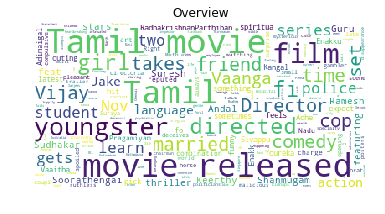

In [68]:
stopwords = set(STOPWORDS)
wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stopwords,
                          max_words=200,
                          max_font_size=40, 
                          random_state=42
                         ).generate(str(md['Overview']))
plt.imshow(wordcloud)
plt.axis('off')
plt.title('Overview')

In [69]:
%%timeit
def cleaning(s):
    s = str(s)
    s = s.lower()
    s = re.sub('\s\W',' ',s)
    s = re.sub('\W,\s',' ',s)
    s = re.sub(r'[^\w]', ' ', s)
    s = re.sub("\d+", "", s)
    s = re.sub('\s+',' ',s)
    s = re.sub('[!@#$_]', '', s)
    s = s.replace("co","")
    s = s.replace("https","")
    s = s.replace(",","")
    s = s.replace("[\w*"," ")
    return s
md['Overview'] = [cleaning(s) for s in md['Overview']]

9.09 ms ± 145 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [70]:
#Print plot overviews of the first 5 movies.
md['Overview'].head()


0    a thriller film directed by sudhakar shanmugam...
1    soorathengai is the tamil film featuring guru ...
2    the movie is directed by andal ramesh and feat...
3    the film stars vijay and keerthy suresh in the...
4    radhakrishnanparthiban s films can be hit and ...
Name: Overview, dtype: object

In [71]:
#Import TfIdfVectorizer from scikit-learn
from sklearn.feature_extraction.text import TfidfVectorizer

#Define a TF-IDF Vectorizer Object. Remove all english stop words such as 'the', 'a'
tfidf = TfidfVectorizer(stop_words='english')

#Replace NaN with an empty string
md['Overview'] = md['Overview'].fillna('')

#Construct the required TF-IDF matrix by fitting and transforming the data
tfidf_matrix = tfidf.fit_transform(md['Overview'])

#Output the shape of tfidf_matrix
tfidf_matrix.shape

(191, 1691)

In [72]:
# Import linear_kernel
from sklearn.metrics.pairwise import linear_kernel

# Compute the cosine similarity matrix
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [73]:
cosine_sim[0]

array([ 1.        ,  0.0791257 ,  0.04333171,  0.12170194,  0.04869945,
        0.09214741,  0.07638808,  0.055337  ,  0.02295348,  0.        ,
        0.02371623,  0.        ,  0.03996045,  0.        ,  0.        ,
        0.        ,  0.01935917,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.0176576 ,  0.        ,  0.        ,  0.05073715,  0.05972802,
        0.12989205,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.04020944,  0.04897837,  0.        ,  0.        ,
        0.04768548,  0.        ,  0.        ,  0.        ,  0.        ,
        0.05691269,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.05207113,  0.        ,
        0.07043293,  0.        ,  0.01985719,  0.05379042,  0.0492001 ,
        0.        ,  0.        ,  0.04479365,  0.        ,  0.03595572,
        0.        ,  0.        ,  0.0566211 ,  0.        ,  0.  

In [74]:
#Construct a reverse map of indices and movie titles
md = md.reset_index()
titles = md['Title']
indices = pd.Series(md.index, index=md['Title']).drop_duplicates()

In [75]:
# Function that takes in movie title as input and outputs most similar movies
def get_recommendations(Title, cosine_sim=cosine_sim):
    # Get the index of the movie that matches the title
    idx = indices[Title]

    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar movies
    sim_scores = sim_scores[1:11]

    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar movies
    return md['Title'].iloc[movie_indices]

In [76]:
get_recommendations('Shivalinga')

108                  Sathura Adi 3500
63     Sangili Bungili Kadhava Thorae
52          Baahubali: The Conclusion
131                     Bayama Irukku
110       Podhuvaga En Manasu Thangam
88                   Yaanum Theeyavan
127                    Thupparivaalan
18                         Kuttram 23
34                     Paambhu Sattai
38                               Dora
Name: Title, dtype: object

In [77]:
get_recommendations('Bairavaa')

153                    Ippadai Vellum
84     Adhagappattathu Magajanangalay
81                             Veruli
30                                465
0              Peiyena Peiyum Kurudhi
147                   Kalathur Gramam
91                          Niranjana
169                             Yaazh
5             Sivappu Enakku Pidikkum
1                        Soorathengai
Name: Title, dtype: object

In [78]:
#Collaborative Filtering
reader = Reader()
ratings = pd.read_csv('Tamil_movies.csv')
ratings.head()

,Title,Director,Cast,Genre,Producer,Vote,Vote Counts,Year,Overview
0,Peiyena Peiyum Kurudhi,Sudhakar Shanmugam,"Jana, Seenivasan, Harish, Ganeshan, Robin",Thriller,Lion Hunters Productions,4.5,28.0,2017,A thriller film directed by Sudhakar Shanmugam...
1,Soorathengai,Sanjeev Srinivas Kanna,"Arvind Vinod, Eugina Samanthi, Theni Murugan",Action masala,Maruthi Films International,5.2,35.0,2017,Soorathengai is the Tamil film featuring Guru ...
2,Unnai Thottu Kolla Vaa,Krishnakumar,"Powerstar Srinivasan, Livingston, Ganja Karuppu",Horror,Kavibharathi Creations,4.6,40.0,2017,The movie is directed by Andal Ramesh and feat...
3,Bairavaa,Bharathan,"Vijay, Keerthy Suresh, Sathish, Jagapati Babu,...",Action masala,Vijaya Productions,7.0,120.0,2017,The film stars Vijay and Keerthy Suresh in the...
4,Koditta Idangalai Nirappuga,Parthiban,"Shanthanu Bhagyaraj, Parvatii Nair, Parthiban,...",Comedy thriller,Reel Estate Company & Bioscope Film Frames,7.0,29.0,2017,RadhakrishnanParthiban’s films can be hit-and-...


In [79]:
md = Dataset.load_from_df(ratings[['Director', 'Genre', 'Vote']], reader)
md.split(n_folds=5)

In [80]:
svd = SVD()
evaluate(svd, md, measures=['RMSE', 'MAE'])

Evaluating RMSE, MAE of algorithm SVD.

------------
Fold 1
RMSE: 2.1224
MAE:  1.7692
------------
Fold 2
RMSE: 1.8613
MAE:  1.5132
------------
Fold 3
RMSE: 2.1208
MAE:  1.8974
------------
Fold 4
RMSE: 1.7317
MAE:  1.5342
------------
Fold 5
RMSE: 1.8947
MAE:  1.6526
------------
------------
Mean RMSE: 1.9462
Mean MAE : 1.6733
------------
------------


CaseInsensitiveDefaultDict(list,
                           {'mae': [1.7692307692307692,
                             1.513157894736842,
                             1.8973684210526314,
                             1.5342105263157895,
                             1.6526315789473685],
                            'rmse': [2.1224079213514502,
                             1.8613096690799535,
                             2.1207620278917121,
                             1.7316709302076752,
                             1.8947295321496416]})

In [81]:
trainset = md.build_full_trainset()
svd.train(trainset)

In [82]:
ratings[ratings['Vote'] == 8.3]

,Title,Director,Cast,Genre,Producer,Vote,Vote Counts,Year,Overview
38,Dora,Doss Ramasamy,"Nayanthara, Sulile Kumar, Harish Uthaman, Tham...",Horror,A Sarkunam Cinemaz & Nemichand Jabak Productions,8.3,538.0,2017,A father and a daughter buy a used car which i...
113,Thappattam,Mujibur Rahman,"Durai Sudhakar, Dona Rozario",Romantic drama,Moon Pictures,8.3,123.0,2017,Thappattam is a Tamil movie released on 24 Aug...
144,Mersal,Atlee,"Vijay, Samantha, Kajal Aggarwal, Nithya Menen,...",Action Thriller,Sri Thenandal Films,8.3,1352.0,2017,"Maaran, a doctor, is invited to Paris for a se..."
164,Guru Uchaththula Irukkaru,B. Dhandapani,"Guru Jeeva, Aara, Pandiarajan, M. S. Bhaskar",Comedy,Best Movies,8.3,156.0,2017,A wastrel and his friends learn that a politic...


In [83]:
svd.predict(1, 302, 3)


Prediction(uid=1, iid=302, r_ui=3, est=5, details={'was_impossible': False})

In [100]:
X_train, X_test, Y_train, Y_test = train_test_split(
        md.loc[:, ['Vote', 'Vote Counts']], 
        md.loc[:, 'Title'])

from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier()#criterion='entropy'
                               #, max_depth = 3
                               #, random_state = 0)
tree.fit(X_train,Y_train)
#Y_pred_tree = tree.predict(X_test)
print ("Training Accuracy {}".format(tree.score(X_train, Y_train)))
#print ("Testing Accuracy {}".format(tree.score(X_test, Y_test)))

Training Accuracy 0.8671328671328671


In [101]:
from sklearn.ensemble import RandomForestClassifier
random = RandomForestClassifier()
random.fit(X_train,Y_train)
#y_pred = random.predict(X_test)
print ("Training Accuracy {}".format(random.score(X_train, Y_train)))
#print ("Testing Accuracy {}".format(random.score(X_test, Y_test)))

Training Accuracy 0.8461538461538461


In [104]:
from sklearn.naive_bayes import BernoulliNB
naive = BernoulliNB()
naive.fit(X_train,Y_train)
#y_pred = random.predict(X_test)
print ("Training Accuracy {}".format(random.score(X_train, Y_train)))
#print ("Testing Accuracy {}".format(random.score(X_test, Y_test)))

Training Accuracy 0.8461538461538461
